In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from childes_mi.utils.paths import DATA_DIR, FIGURE_DIR
from childes_mi.utils.general import flatten,save_fig

In [3]:
from childes_mi.information_theory import model_fitting as mf

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
MI_DF = pd.read_pickle(DATA_DIR/'mi/childes_mi.pickle')

In [6]:
MI_DF[:3]

,MI,MI_var,shuff_MI,shuff_MI_var,distances,age_cohort_low,age_cohort_high,n_words,n_unique_words
0,"[6.0615547382637684, 5.953026573946322, 5.8999...","[0.06497202939114834, 0.06421181443545038, 0.0...","[5.79799893493386, 5.805771966570329, 5.792474...","[0.06474471004074468, 0.06537742978608413, 0.0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.5,1,2371,72
1,"[10.373016081368098, 10.130972857078175, 9.987...","[0.00937963690006051, 0.009307961610168364, 0....","[9.60947032947951, 9.60572819037825, 9.5994570...","[0.009097935454051041, 0.009124346562127784, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.0,1.5,67747,3609
2,"[11.349881924265677, 11.087999639009142, 10.96...","[0.005174827403727939, 0.005136394630766223, 0...","[10.681207621740015, 10.677630292519837, 10.67...","[0.005060342080401666, 0.005066649080465537, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.5,2,232191,8134


In [7]:
MI_DF = MI_DF.assign(**{i:np.nan for i in ['exp_results', 'pow_results', 'concat_results',
     'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
     'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature', 'min_peak']})
MI_DF['curvature'] = MI_DF['curvature'].astype(object)

In [8]:
n = 100 # max distance for computation
for idx, row in tqdm(MI_DF.iterrows(), total=len(MI_DF)):
    # get signal
    sig = np.array(row.MI-row.shuff_MI)
    distances = row.distances
    
    sig = sig
    
    # fit models
    results_power, results_exp, results_pow_exp, best_fit_model = mf.fit_models(distances, sig)
    
    # get fit results
    R2_exp, R2_concat, R2_power, AICc_exp, \
        AICc_pow, AICc_concat = mf.fit_results(sig, distances, 
                                              results_exp, results_power,
                                              results_pow_exp)
    
    
    # get model y
    distances_mod = np.logspace(0,np.log10(n), base=10, num=1000)
    if best_fit_model == 'pow_exp':
        y_model = mf.get_y(mf.pow_exp_decay, results_pow_exp, distances_mod)
    elif best_fit_model == 'exp':
        y_model = mf.get_y(mf.exp_decay, results_exp, distances_mod)
    elif best_fit_model == 'pow':
        y_model = mf.get_y(mf.powerlaw_decay, results_power, distances_mod)
    
    # get curvature of model_y
    curvature_model = mf.curvature(np.log(y_model))
    
    # if the best fit model is pow_exp, then grab the min peak
    if best_fit_model == 'pow_exp':
        # get peaks of curvature
        peaks = np.where((
            (curvature_model[:-1] < curvature_model[1:])[1:] & (curvature_model[1:] < curvature_model[:-1])[:-1]
        ))
        min_peak = peaks[0][0]
    else:
        min_peak = np.nan

    # get save model fit results to MI_DF
    MI_DF.loc[idx, np.array(['exp_results', 'pow_results', 'concat_results',
                         'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
                         'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature', 'min_peak'])] = [
        results_exp, results_power, results_pow_exp,
        R2_exp, R2_concat, R2_power, AICc_exp,
        AICc_concat, AICc_pow, best_fit_model,
        curvature_model, min_peak
    ]

    print(row.age_cohort_low, row.age_cohort_high, best_fit_model)

/mnt/cube/tsainbur/Projects/github_repos/childes_mi_project/childes_mi/information_theory/model_fitting.py:8: RuntimeWarning: invalid value encountered in log
  return np.abs(np.log(y_true) - np.log(y_model)) * (1 / (np.log(1 + x)))


0.5 1 exp
1.0 1.5 pow_exp
1.5 2 pow_exp
2.0 2.5 pow_exp
2.5 3 pow_exp
3.0 20 pow_exp



In [9]:
MI_DF[:3]

,MI,MI_var,shuff_MI,shuff_MI_var,distances,age_cohort_low,age_cohort_high,n_words,n_unique_words,exp_results,...,concat_results,R2_exp,R2_concat,R2_power,AICc_exp,AICc_concat,AICc_power,bestfitmodel,curvature,min_peak
0,"[6.0615547382637684, 5.953026573946322, 5.8999...","[0.06497202939114834, 0.06421181443545038, 0.0...","[5.79799893493386, 5.805771966570329, 5.792474...","[0.06474471004074468, 0.06537742978608413, 0.0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.5,1,2371,72,<lmfit.minimizer.MinimizerResult object at 0x7...,...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.803612,0.804922,0.776286,-136.562178,-132.408084,-127.833763,exp,"[-3.6367098727388944e-06, -5.463370893703798e-...",NaN
1,"[10.373016081368098, 10.130972857078175, 9.987...","[0.00937963690006051, 0.009307961610168364, 0....","[9.60947032947951, 9.60572819037825, 9.5994570...","[0.009097935454051041, 0.009124346562127784, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.0,1.5,67747,3609,<lmfit.minimizer.MinimizerResult object at 0x7...,...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.960713,0.986984,0.980082,-420.636087,-526.718807,-488.563146,pow_exp,"[6.528048763553539e-07, 9.767024895467008e-07,...",450.0
2,"[11.349881924265677, 11.087999639009142, 10.96...","[0.005174827403727939, 0.005136394630766223, 0...","[10.681207621740015, 10.677630292519837, 10.67...","[0.005060342080401666, 0.005066649080465537, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.5,2,232191,8134,<lmfit.minimizer.MinimizerResult object at 0x7...,...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.949823,0.989080,0.985398,-360.792506,-505.839244,-481.766416,pow_exp,"[9.60855604404184e-07, 1.4398265135829119e-06,...",435.0


3.0

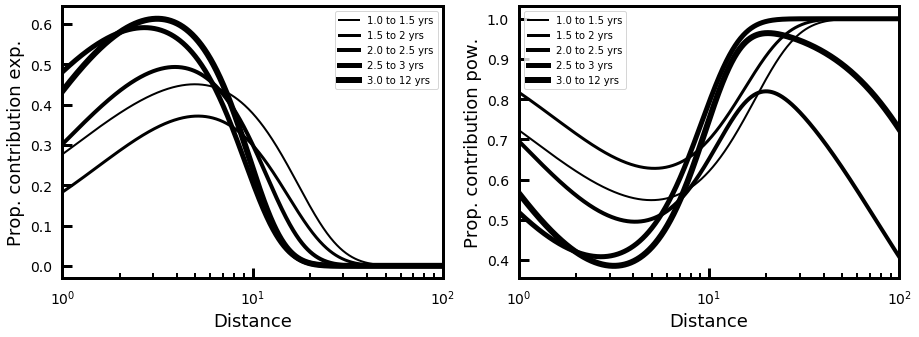

In [14]:
fig, axs = plt.subplots(ncols=2, figsize=(15,5))
for axi, (idx, row) in enumerate(MI_DF.sort_values(by=['age_cohort_low']).iterrows()):
    if row.age_cohort_low == 0.5: continue
    sig = np.array(row.MI-row.shuff_MI)
    distances = row.distances
    sig = sig
    distances_model = np.logspace(0,np.log10(distances[-1]), base=10, num=1000)
    y_model = mf.get_y(mf.pow_exp_decay, row.concat_results, distances_model)
    y_pow = mf.get_y(mf.powerlaw_decay, row.concat_results, distances_model) - row.concat_results.params['intercept'].value
    y_exp = mf.get_y(mf.exp_decay, row.concat_results, distances_model) - row.concat_results.params['intercept'].value
    #ac_high = np.min([row.age_cohort_high, 4])
    ac_high = np.min([row.age_cohort_high, 12])
    lab = "{} to {} yrs".format(row.age_cohort_low, ac_high)

    axs[0].plot(distances_model, y_exp/y_model, color = 'k', ls='solid', lw = axi+1, label = lab)
    axs[1].plot(distances_model, y_pow/y_model, color = 'k', ls='solid', lw = axi+1, label = lab)
    
axs[0].set_ylabel('Prop. contribution exp.', labelpad=5, fontsize=18)
axs[1].set_ylabel('Prop. contribution pow.', labelpad=5, fontsize=18)
    
for ax in axs:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(3)
        ax.spines[axis].set_color('k')
    ax.set_xticks([1,10,100])
    ax.set_xticklabels(['1','10','100'])
    ax.tick_params(which='both', direction='in', labelsize=14, pad=10)
    ax.tick_params(which='major', length=10, width =3)
    ax.tick_params(which='minor', length=5, width =2)
    ax.set_xlim([1,100])
    ax.set_xscale( "log" , basex=10)
    ax.legend()
    ax.set_xlabel('Distance', labelpad=5, fontsize=18)

save_fig(FIGURE_DIR/'CHILDES_model_contribution')